Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')


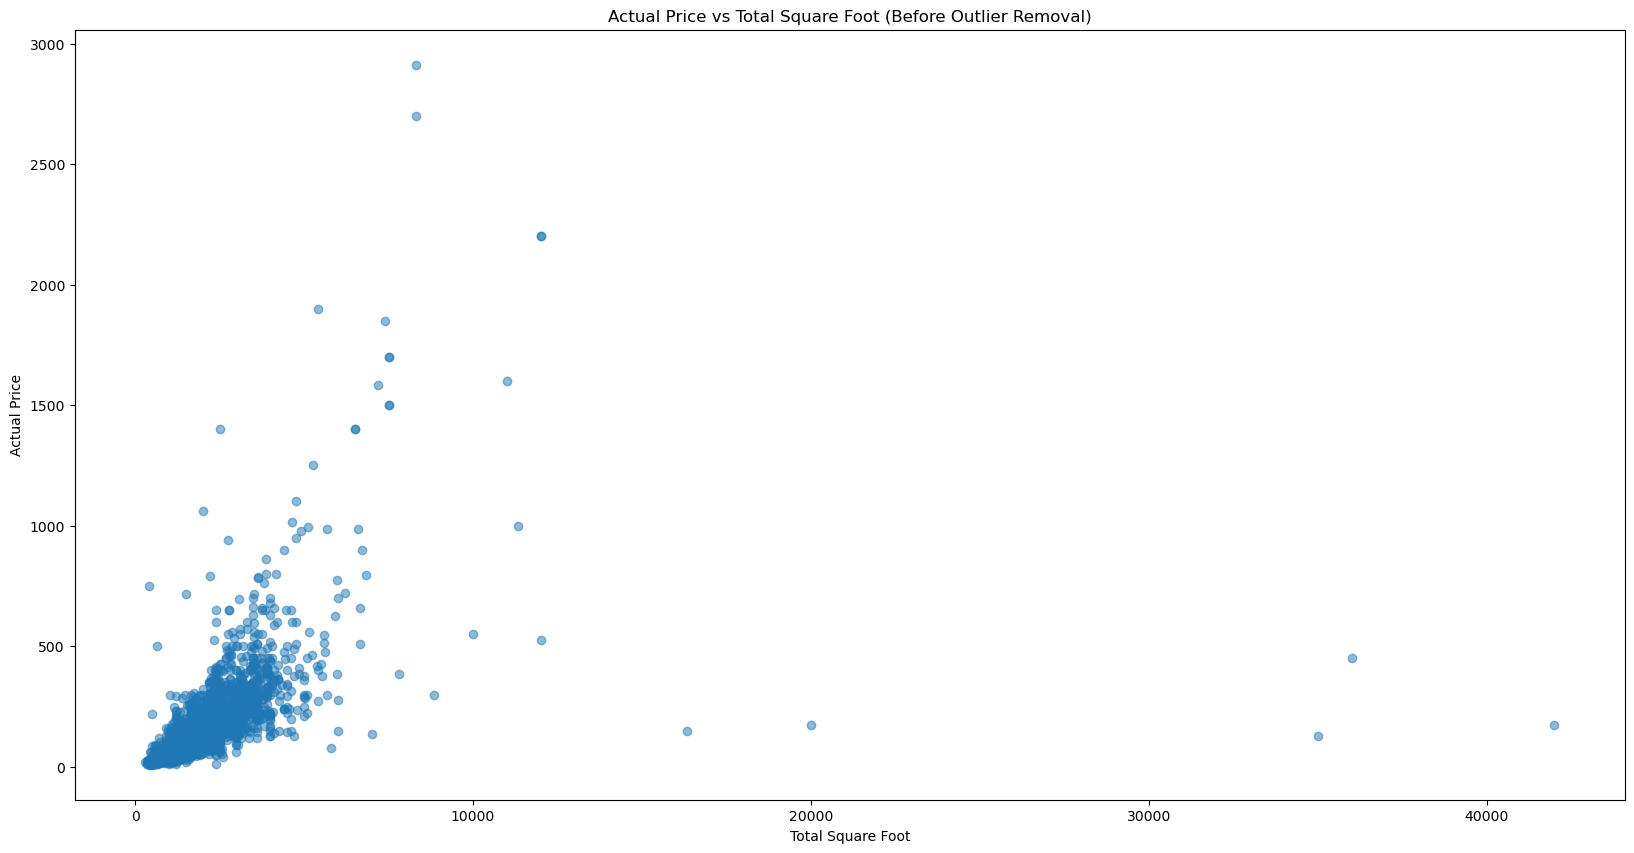

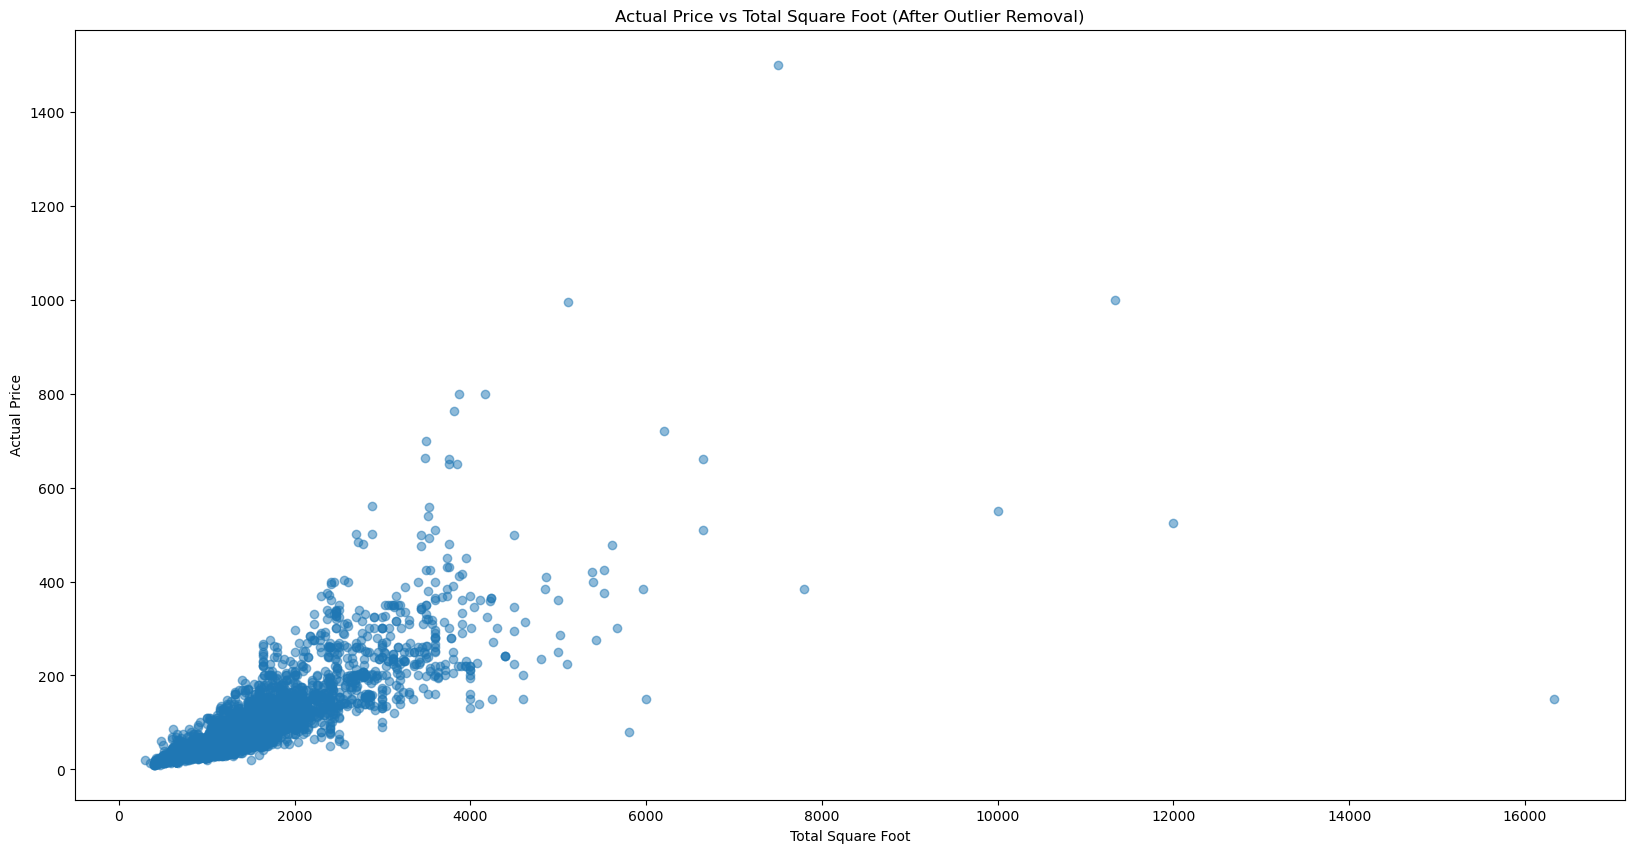

Test score: 0.6009790143129111
Cross-validation scores:  [0.59432327 0.58096138 0.59398928 0.62427326 0.61090743]


In [29]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20, 10)

# Load the dataset
df = pd.read_csv(r"C:\Users\S221032134\Downloads\House.csv")

# Check the columns to see if 'bhk' exists
print(df.columns)

# If 'bhk' column is missing, create it from 'size' column
if 'bhk' not in df.columns:
    # Convert all entries to string, handle NaN values as empty strings
    df['bhk'] = df['size'].apply(lambda x: int(str(x).split(' ')[0]) if isinstance(x, str) and 'BHK' in x else np.nan)

# Now perform the preprocessing steps

# Helper function to check if a value can be converted to float
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

# Function to convert sqft ranges to numeric values
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1])) / 2
    try:
        return float(x)
    except:
        return None

# Copy DataFrame to avoid modifying original data
df2 = df.copy()

# Apply the conversion function to 'total_sqft' column
df2['total_sqft'] = df2['total_sqft'].apply(convert_sqft_to_num)

# Remove rows with null values in 'total_sqft'
df2 = df2[df2['total_sqft'].notnull()]

# Analyze price per sqft statistics
df2['price_per_sqft'] = df2['price'] / df2['total_sqft']
df2_stats = df2['price_per_sqft'].describe()

# Clean 'location' column by stripping spaces, but handle NaN or non-string values
df2['location'] = df2['location'].apply(lambda x: x.strip() if isinstance(x, str) else x)

# Handle any NaN values in the 'location' column by filling with 'Unknown' (or you can drop them)
df2 = df2[df2['location'].notnull()]  # Optionally drop rows with NaN in 'location'

# Get value counts of locations
location_stats = df2['location'].value_counts(ascending=False)

# Categorize locations with fewer than 10 occurrences as 'other'
location_stats_less_than_10 = location_stats[location_stats < 10].index
df2['location'] = df2['location'].apply(lambda x: 'other' if x in location_stats_less_than_10 else x)

# Filter rows where 'total_sqft' per 'bhk' is less than 300
df2 = df2[df2['total_sqft'] / df2['bhk'] >= 300]

# Function to remove price-per-sqft outliers within each location
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf['price_per_sqft'])
        st = np.std(subdf['price_per_sqft'])
        reduced_df = subdf[(subdf['price_per_sqft'] > (m - st)) & (subdf['price_per_sqft'] <= (m + st))]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)
    return df_out

# Before outlier removal: Scatter plot of actual price vs total_sqft
plt.figure(figsize=(20, 10))
plt.scatter(df2['total_sqft'], df2['price'], alpha=0.5)
plt.title('Actual Price vs Total Square Foot (Before Outlier Removal)')
plt.xlabel('Total Square Foot')
plt.ylabel('Actual Price')
plt.show()

# Remove price-per-sqft outliers
df2_no_pps_outliers = remove_pps_outliers(df2)

# After outlier removal: Scatter plot of actual price vs total_sqft
plt.figure(figsize=(20, 10))
plt.scatter(df2_no_pps_outliers['total_sqft'], df2_no_pps_outliers['price'], alpha=0.5)
plt.title('Actual Price vs Total Square Foot (After Outlier Removal)')
plt.xlabel('Total Square Foot')
plt.ylabel('Actual Price')
plt.show()

# Function to remove BHK outliers
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df['price_per_sqft']),
                'std': np.std(bhk_df['price_per_sqft']),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk - 1)
            if stats and stats['count'] > 5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df['price_per_sqft'] < stats['mean']].index.values)
    return df.drop(exclude_indices, axis='index')

# Remove BHK outliers
df2_no_bhk_outliers = remove_bhk_outliers(df2_no_pps_outliers)

# Filter out rows where the number of bathrooms is greater than BHK + 2
df2_no_bhk_outliers = df2_no_bhk_outliers[df2_no_bhk_outliers['bath'] <= df2_no_bhk_outliers['bhk'] + 2]

# Drop columns that are no longer needed
df2_no_bhk_outliers = df2_no_bhk_outliers.drop(['size', 'price_per_sqft'], axis='columns')

# One-hot encode the 'location' column
dummies = pd.get_dummies(df2_no_bhk_outliers['location'])
df2_no_bhk_outliers = pd.concat([df2_no_bhk_outliers, dummies.drop('other', axis='columns')], axis='columns')

# Drop the 'location' column after encoding
df2_no_bhk_outliers = df2_no_bhk_outliers.drop('location', axis='columns')

# Split the data into features (X) and target (y)
X = df2_no_bhk_outliers.drop(['price'], axis='columns')
y = df2_no_bhk_outliers['price']

# Now let's import machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.datasets import fetch_california_housing

# Use California housing dataset as a modern replacement for Boston housing dataset
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Fit the model using training data
lr_clf = LinearRegression()
lr_clf.fit(X_train, y_train)

# Get the model score on the test data
score = lr_clf.score(X_test, y_test)
print(f"Test score: {score}")

# Perform cross-validation using ShuffleSplit
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
scores = cross_val_score(LinearRegression(), X, y, cv=cv)

# Print the cross-validation scores
print("Cross-validation scores: ", scores)